<a href="https://colab.research.google.com/github/4juneko/Aiffel_work/blob/master/16_makeLyrics_50292023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubric
|평가문항	|상세기준|내 평가|
|--|--|--|
|1. 데이터의 전처리 및 구성과정이 체계적으로 진행되었는가?	|특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?|O|
|2. 가사 텍스트 생성 모델이 정상적으로 동작하는가?	|텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?|O|
|3. 텍스트 생성모델이 안정적으로 학습되었는가?	|텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?|O|

In [ ]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow
import os, re 
import tensorflow as tf

print(tensorflow.__version__)

2.6.0


# Download Data
~/aiffel/lyricist/data/lyrics

# Open Data

In [ ]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


# Preprocess Data

In [ ]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

[Spoken Intro:]
You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 


In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1. 소문자로, 공백 없애기
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개 공백은 공백 하나로
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4. ^a-zA-Z?.!,¿을 제외하고 공백으로
    sentence = sentence.strip() # 5. 양쪽 공백 지우기. 1번에서도 공백 없애기 했는데 두번째이네
    sentence = '<start> ' + sentence + ' <end>' # 6. 처음에는 start, 끝에는 end 넣기
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [ ]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

In [ ]:
# 토큰화 문자를 숫자로...

# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>" # out-of-vocabulary, 사전에 없는 단어
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  #  토큰의 갯수 20개를 넘어가지 않게
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   2  735    5 ...    0    0    0]
 [   2  735    5 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f727961f1c0>


In [ ]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [ ]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[2701 2584    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


# Split Data
- 단어장의 크기는 12,000 이상 으로 설정하세요!  
- 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [ ]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                    tgt_input, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=1004)

In [ ]:
print(enc_train.shape, enc_val.shape)

(140599, 19) (35150, 19)


In [ ]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

# Model

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

In [ ]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 19, 7001), dtype=float32, numpy=
array([[[-9.74357608e-05,  3.46262910e-04,  1.01655045e-04, ...,
         -5.99511004e-05,  1.63110744e-04, -3.61824030e-04],
        [ 3.45586013e-05,  6.31571980e-04, -2.36904336e-04, ...,
         -2.38232693e-04, -5.33414481e-04, -4.75491979e-04],
        [ 3.24357999e-04,  1.10829342e-03, -1.45535727e-04, ...,
          2.46793817e-04, -6.12090225e-04, -6.05171430e-04],
        ...,
        [ 2.02675862e-03, -2.21047737e-03, -4.80021769e-03, ...,
         -4.76310542e-03,  3.56668816e-03, -7.24541023e-03],
        [ 1.97441084e-03, -2.39605829e-03, -5.14235999e-03, ...,
         -5.24392724e-03,  3.74352629e-03, -7.47720478e-03],
        [ 1.92754797e-03, -2.53265142e-03, -5.41911880e-03, ...,
         -5.67735359e-03,  3.90527234e-03, -7.67374178e-03]],

       [[-9.74357608e-05,  3.46262910e-04,  1.01655045e-04, ...,
         -5.99511004e-05,  1.63110744e-04, -3.61824030e-04],
        [ 1.44383521e-04,  6.45552180e-04, -7.

In [ ]:
# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3584512   
_________________________________________________________________
lstm (LSTM)                  multiple                  20979712  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  14345049  
Total params: 72,471,897
Trainable params: 72,471,897
Non-trainable params: 0
_________________________________________________________________


# Train
- 모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!
- val_loss 값은 2.2 아래로 떨어지지 않습니다. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
# # optimizer와 loss등은 차차 배웁니다
# # 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# # https://www.tensorflow.org/api_docs/python/tf/keras/losses
# # 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

# # Adam 알고리즘을 구현하는 optimzier이며 어떤 optimzier를 써야할지 모른다면 Adam을 쓰는 것도 방법이다.
# # 우리가 학습을 할 때 최대한 틀리지 않는 방향으로 학습을 해야한다.
# # 여기서 얼마나 틀리는지(loss)를 알게하는 함수가 손실함수 이다.
# # 이 손실함수의 최소값을 찾는 것을 학습의 목표로 하며 여기서 최소값을 찾아가는 과정을 optimization 이라하고
# # 이를 수행하는 알고리즘을 optimizer(최적화)라고 한다.

# optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
# loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
#     from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
#     reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
# )
# # 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
# model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
# history1 = model.fit(dataset, 
#           epochs=10,
#           validation_data = val_dataset) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

Epoch 1/10
549/549 [==============================] - 335s 601ms/step - loss: 2.6131 - val_loss: 2.2965
Epoch 2/10
549/549 [==============================] - 334s 609ms/step - loss: 2.1442 - val_loss: 2.0735
Epoch 3/10
549/549 [==============================] - 335s 610ms/step - loss: 1.8885 - val_loss: 1.9297
Epoch 4/10
549/549 [==============================] - 336s 611ms/step - loss: 1.6431 - val_loss: 1.8277
Epoch 5/10
549/549 [==============================] - 336s 612ms/step - loss: 1.4097 - val_loss: 1.7557
Epoch 6/10
549/549 [==============================] - 336s 613ms/step - loss: 1.1972 - val_loss: 1.7131
Epoch 7/10
549/549 [==============================] - 336s 612ms/step - loss: 1.0208 - val_loss: 1.6965
Epoch 8/10
549/549 [==============================] - 336s 612ms/step - loss: 0.8873 - val_loss: 1.7051
Epoch 9/10
549/549 [==============================] - 336s 612ms/step - loss: 0.8028 - val_loss: 1.7206
Epoch 10/10
549/549 [==============================] - 336s 613m

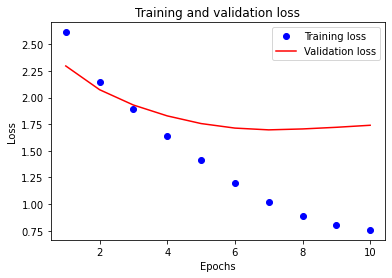

In [ ]:
# # graph
# import matplotlib.pyplot as plt

# loss = history1.history['loss']
# val_loss = history1.history['val_loss']

# epochs_range = range(1, len(loss)+1)

# plt.plot(epochs_range, loss, 'bo', label='Training loss')
# plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()
# # epoch 3 이후부터 overfit.. 
# # epoch 3에서 멈추는 것이 낫겠음.

In [ ]:
# overfit으로 다시 학습 epoch 3

optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
history2 = model.fit(dataset, 
          epochs=3,
          validation_data = val_dataset) # 만들어둔 데이터셋으로 모델을 학습한다. 3번 학습을 반복하겠다는 의미다.

Epoch 1/3
549/549 [==============================] - 324s 581ms/step - loss: 2.6089 - val_loss: 2.3252
Epoch 2/3
549/549 [==============================] - 321s 585ms/step - loss: 2.1902 - val_loss: 2.1235
Epoch 3/3
549/549 [==============================] - 323s 587ms/step - loss: 1.9691 - val_loss: 1.9843


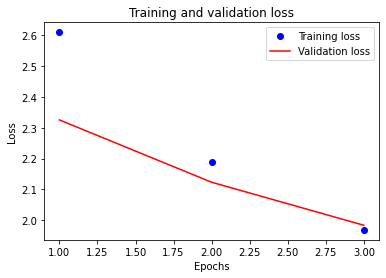

In [ ]:
# graph
import matplotlib.pyplot as plt

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(1, len(loss)+1)

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# Save & Load a trained model

In [ ]:
# save trained model
from keras.models import load_model
# model.save_weights('lyrics_model.h5')

model.save('lyrics_model',save_format='tf')

INFO:tensorflow:Assets written to: lyrics_model/assets


INFO:tensorflow:Assets written to: lyrics_model/assets


In [ ]:
# load saved model
# 이 프로젝트의 모델을 자유도가 높은 sub_classing model이기 때문에 structure가 저장되지 않음.
# load model할 때 structure를 먼저 부르고 weights를 load하면 됨.
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#load_weights
# https://wikidocs.net/106897

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
model1 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

import keras
from keras.models import load_model

model1.load_weights(filepath='lyrics_model')

In [ ]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

# Generate text

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i love") #I love를 시작으로 하는 문장... 

'<start> i love you , i love you <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i") # I로 시작하는 문장. 슬프네..

'<start> i m gonna marry the night <end> '

In [ ]:
generate_text(model1, tokenizer, init_sentence="<start> i love") # 저장했던 모델을 불러와서 문장 생성 저장 전 원래 모델과 같은 결과

'<start> i love you , i love you <end> '

In [ ]:
generate_text(model1, tokenizer, init_sentence="<start> i") # 저장했던 모델을 불러와서 문장 생성

'<start> i m gonna marry the night <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> you") 

'<start> you re the only one that s ever gonna say <end> '

# Review
- Embedding Size와 Hidden Size를 바꾸어 가며 학습함.
- embedding_size = 512, hidden_size = 2048에서 loss 2.2 이하의 결과를 얻을 수 있었음.
- epochs 3이 넘어가면서 overfit이 되어 3에서 멈춤
- model을 저장하여 코드 파일을 열 때마다 저장할 필요없게 하는데 사용한 모델이 자유도가 높은 sub_classing model이기 때문에 structure가 저장되지 않고 weights만 저장됨.
- load model시에 structure를 먼저 부르고 load weights => 정상적으로 저장된 모델을 불러올 수 있었음.
- I love 뒤의 생성 문장은 I love you. I love you.
- I 뒤의 생성 문장은 i m gonna marry the night.
- 저장 전의 모델과 저장한 뒤 불러온 모델의 생성 문장은 같았음.